In [5]:
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, Union

import pandas as pd
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from loguru import logger
from mads_datasets import DatasetFactoryProvider, DatasetType
from matplotlib import pyplot as plt
import mlflow
from mltrainer import ReportTypes, Trainer, TrainerSettings, metrics
from mltrainer.preprocessors import BasePreprocessor
from pydantic import BaseModel
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
flowers_dataset_factory = DatasetFactoryProvider.create_factory(
    DatasetType.FLOWERS
)

In [3]:
data_streamer = flowers_dataset_factory.create_datastreamer(
    batchsize=64,
    preprocessor=BasePreprocessor(),
)
train_streamer = data_streamer["train"].stream()
valid_streamer = data_streamer["valid"].stream()

2026-01-15 10:42:17.161 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/koendirkvanesterik/.cache/mads_datasets/flowers


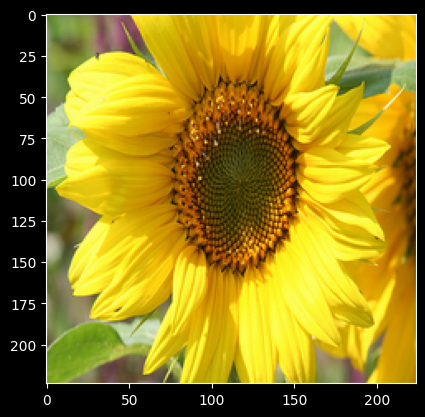

In [4]:
image, label = next(train_streamer)

index = 2
first_image = image[index]
first_image = first_image.permute(1, 2, 0)

plt.imshow(first_image)
plt.show()

In [5]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("mlflow-flowers-hyperopt")

2026/01/15 10:42:26 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/15 10:42:26 INFO mlflow.store.db.utils: Updating database tables
2026-01-15 10:42:26 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2026-01-15 10:42:26 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2026-01-15 10:42:26 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2026-01-15 10:42:26 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/Users/koendirkvanesterik/Projects/mads/mads-ml-koenvanesterik/notebooks/hypertuning/mlruns/1', creation_time=1768406934538, experiment_id='1', last_update_time=1768406934538, lifecycle_stage='active', name='mlflow-flowers-hyperopt', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [6]:
class ModelConfig(BaseModel):
    features: int
    num_classes: int
    kernel_size: int
    filter1: int
    filter2: int
    dropout: float = 0
    has_batchnorm: bool = True


class FlowersModel(nn.Module):
    def __init__(
        self,
        config: ModelConfig,
    ) -> None:
        super().__init__()

        self._convolutions = nn.Sequential(
            nn.Conv2d(
                in_channels=config.features,
                out_channels=config.filter1,
                kernel_size=config.kernel_size,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(config.filter1) if config.has_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=config.filter1,
                out_channels=config.filter2,
                kernel_size=config.kernel_size,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(config.filter2) if config.has_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=config.filter2,
                out_channels=32,
                kernel_size=config.kernel_size,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(32) if config.has_batchnorm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        self._dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(64, config.num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._convolutions(x)
        return self._dense(x)

In [12]:
settings = TrainerSettings(
    epochs=50,
    metrics=[metrics.Accuracy()],
    logdir="modellogs",
    train_steps=180,
    valid_steps=180,
    reporttypes=[ReportTypes.MLFLOW, ReportTypes.TOML],
)

In [8]:
def objective(params: Dict[str, Union[int, float]]) -> Dict[str, Any]:
    with mlflow.start_run():
        mlflow.set_tag("model", "cnn")
        mlflow.set_tag("dev", "vanesterik")
        mlflow.log_params(params)

        model = FlowersModel(ModelConfig(**params))
        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=nn.CrossEntropyLoss(),
            optimizer=optim.Adam,
            traindataloader=train_streamer,
            validdataloader=valid_streamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau,
            device=torch.device("mps"),
        )
        trainer.loop()

        tag = datetime.now().strftime("%Y%m%d-%H%M")
        models_dir = Path("models").resolve()

        if not models_dir.exists():
            models_dir.mkdir()
            logger.info(f"Created {models_dir}")

        models_path = models_dir / (tag + "model.pt")
        torch.save(model, models_path)

        mlflow.log_artifact(
            local_path=models_path, artifact_path="pytorch_models"
        )

        return {"loss": trainer.test_loss, "status": STATUS_OK}


In [13]:
search_space = {
    "dropout": 0.25428392690546453,
    "features": 3,
    "filter1": 64,
    "filter2": 32,
    "kernel_size": 3,
    "num_classes": 5,
    "has_batchnorm": hp.choice("has_batchnorm", [True, False]),
}

In [14]:
results = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=2,
    trials=Trials(),
)

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

2026-01-15 13:01:06.914 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20260115-130106
2026-01-15 13:01:06.923 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 180/180 [01:06<00:00,  2.69it/s]
2026-01-15 13:02:32.503 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.3495 test 1.2055 metric ['0.4888']
100%|##########| 180/180 [01:05<00:00,  2.76it/s]
2026-01-15 13:03:56.113 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 1.1428 test 1.1296 metric ['0.5547']
100%|##########| 180/180 [01:05<00:00,  2.77it/s]
2026-01-15 13:05:19.453 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 1.0845 test 1.0476 metric ['0.5853']
100%|##########| 180/180 [01:05<00:00,  2.75it/s]
2026-01-15 13:06:43.414 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 1.0404 test 1.0146 metric ['0.6232']
100%|##########| 180/180 [01:05<00:00,  2.74it/s]
2026-01-15 

 50%|█████     | 1/2 [1:09:32<1:09:32, 4172.13s/trial, best loss: 0.692761259774367]

2026-01-15 14:10:39.005 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20260115-141039
2026-01-15 14:10:39.011 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 180/180 [01:38<00:00,  1.84it/s]
2026-01-15 14:12:41.676 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.1589 test 0.9575 metric ['0.6298']
100%|##########| 180/180 [01:34<00:00,  1.90it/s]
2026-01-15 14:14:41.243 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.9013 test 1.0379 metric ['0.5637']
2026-01-15 14:14:41.244 | INFO     | mltrainer.trainer:__call__:252 - best loss: 0.9575, current loss 1.0379.Counter 1/10.
100%|##########| 180/180 [01:34<00:00,  1.91it/s]
2026-01-15 14:16:40.177 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.8017 test 0.8558 metric ['0.6733']
100%|##########| 180/180 [01:34<00:00,  1.91it/s]
2026-01-15 14:18:38.786 | INFO     | mltrainer.trainer:re

100%|██████████| 2/2 [2:00:04<00:00, 3602.07s/trial, best loss: 0.629907359348403]  


In [15]:
logger.info(f"\n\n{results}")

2026-01-15 15:01:11.001 | INFO     | __main__:<module>:1 - 

{'has_batchnorm': np.int64(0)}


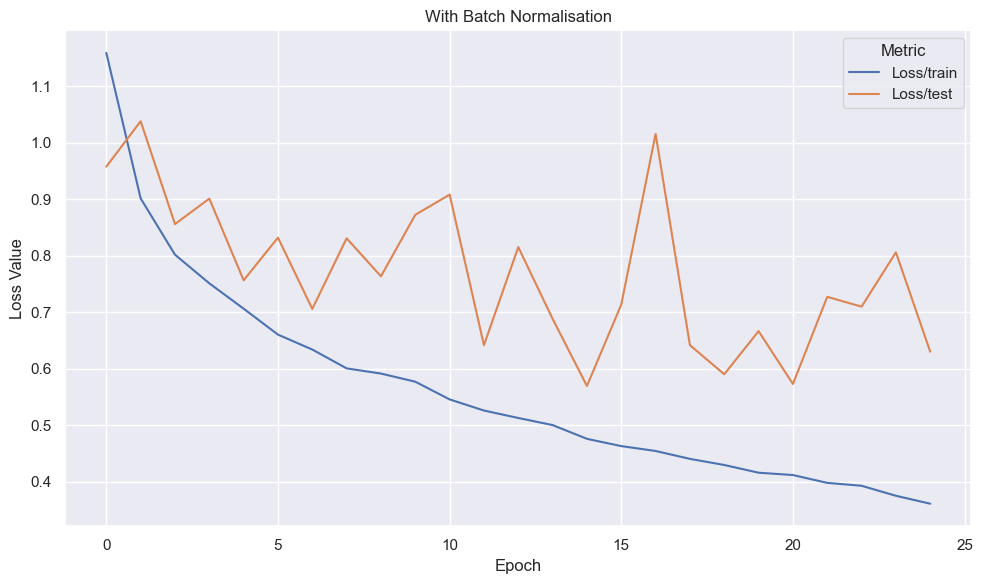

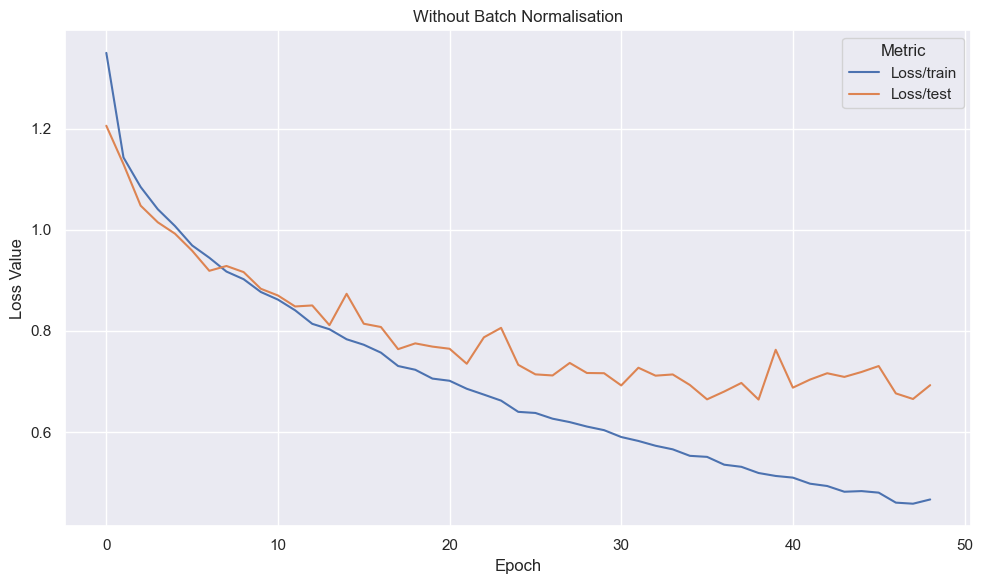

In [14]:
datasets = ['with_batchnorm.csv', 'without_batchnorm.csv']

sns.set_theme(style="darkgrid")

for dataset in datasets:
    df = pd.read_csv(dataset)
    
    # Filter for train and test loss metrics
    df_filtered = df[df['metric'].isin(['Loss/train', 'Loss/test'])]
    
    # Create lineplot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_filtered, x='step', y='value', hue='metric')
    plt.title("With Batch Normalisation" if dataset == "with_batchnorm.csv" else "Without Batch Normalisation")
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.savefig(f"../../assets/images/{dataset.replace('.csv', '.png')}")
    plt.show()
